# SwissMetro
> Reproducing this example from [biogeme](https://github.com/michelbierlaire/biogeme/blob/working/examples/notebooks/My%20first%20model.ipynb)

In [ ]:
from pathlib import Path
import pandas as pd
from fastcore.all import *
from pytorch_mnl.core import *

In [ ]:
PATH = Path('data')

In [ ]:
df = pd.read_csv(PATH/'swissmetro.dat', '\t')
df.head()

,GROUP,SURVEY,SP,ID,PURPOSE,FIRST,TICKET,WHO,LUGGAGE,AGE,...,TRAIN_TT,TRAIN_CO,TRAIN_HE,SM_TT,SM_CO,SM_HE,SM_SEATS,CAR_TT,CAR_CO,CHOICE
0,2,0,1,1,1,0,1,1,0,3,...,112,48,120,63,52,20,0,117,65,2
1,2,0,1,1,1,0,1,1,0,3,...,103,48,30,60,49,10,0,117,84,2
2,2,0,1,1,1,0,1,1,0,3,...,130,48,60,67,58,30,0,117,52,2
3,2,0,1,1,1,0,1,1,0,3,...,103,40,30,63,52,20,0,72,52,2
4,2,0,1,1,1,0,1,1,0,3,...,130,36,60,63,42,20,0,90,84,2


Remove some observations


In [ ]:
exclude = df.query('(PURPOSE != 1 and PURPOSE != 3) or CHOICE == 0')

In [ ]:
df = df.drop(exclude.index)
len(df)

6768

Model Params

In [ ]:
# ASC_CAR = Beta('ASC_CAR', 0, None, None, 0)
# ASC_TRAIN = Beta('ASC_TRAIN', 0, None, None, 0)
# ASC_SM = Beta('ASC_SM', 0, None, None, 1)
# B_TIME = Beta('B_TIME', 0, None, None, 0)
# B_COST = Beta('B_COST', 0, None, None, 0)

Definition of new variables

In [ ]:
df = df.assign(SM_COST = df['SM_CO'] * (df['GA'] == 0),
               TRAIN_COST = df['TRAIN_CO'] * (df['GA'] == 0))

df = df.assign(CAR_AV_SP = df['CAR_AV'] * (df['SP'] != 0),
               TRAIN_AV_SP = df['TRAIN_AV'] * (df['SP'] != 0),
               TRAIN_TT_SCALED = df['TRAIN_TT'] / 100,
               TRAIN_COST_SCALED = df['TRAIN_COST'] / 100,
               SM_TT_SCALED = df['SM_TT'] / 100,
               SM_COST_SCALED = df['SM_COST'] / 100,
               CAR_TT_SCALED = df['CAR_TT'] / 100,
               CAR_CO_SCALED = df['CAR_CO'] / 100)

## Utility Func
> you have to define your model as a nn.Module

In [ ]:
# V1 = ASC_TRAIN + \
#      B_TIME * TRAIN_TT_SCALED + \
#      B_COST * TRAIN_COST_SCALED
# V2 = ASC_SM + \
#      B_TIME * SM_TT_SCALED + \
#      B_COST * SM_COST_SCALED
# V3 = ASC_CAR + \
#      B_TIME * CAR_TT_SCALED + \
#      B_COST * CAR_CO_SCALED

$$V = a + b\cdot x $$

In [ ]:
import torch
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self, n_params=2, n_choices=3,  bias=True):
        super().__init__()
        self.available = Availability(n_choices, inf=100)
        
        self.b = nn.Parameter(torch.zeros(n_params,1))
        if bias:
            self.a = nn.Parameter(torch.zeros(n_choices-1, 1))
        else:
            self.a = torch.zeros(n_choices-1, 1)  #non trainable
        
    def forward(self, x, av):
        a = torch.cat([torch.zeros(1,1, device=x.device), self.a])
        logits = (a + x @ self.b).squeeze()
        return self.available(logits, av)
    
    def get_params(self):
        return {'a': torch.cat([torch.zeros(1,1), self.a.cpu()]), 'b': self.b}

In [ ]:
x_cols =  ['SM_TT_SCALED',
           'SM_COST_SCALED',
           'TRAIN_TT_SCALED',
           'TRAIN_COST_SCALED',
           'CAR_TT_SCALED',
           'CAR_CO_SCALED']

av = ['SM_AV',
      'TRAIN_AV_SP',
      'CAR_AV_SP']

n_choices = len(av)
n_params = 2 # TT and CO

In [ ]:
model = LinearModel(n_params=n_params, n_choices=n_choices, bias=True)

in the original dataframe:
- 1 is Train
- 2 is SM 
- 3 is Car

In [ ]:
target_map = {1: 1, 2: 0, 3:2}  #I reorder to put SM_TT as first

# Prepare data

In [ ]:
X, y, avs = prepare_data(df, x_cols=x_cols, target_col='CHOICE', av_cols=av, target_map=target_map)

{1: 1, 2: 0, 3: 2}


we have to reshape the inputs to have `n_params` at the end.

In [ ]:
X = X.reshape(-1,n_choices, n_params)

it is the same thing, but matrix oriented

In [ ]:
X[0]

tensor([[0.6300, 0.5200],
        [1.1200, 0.4800],
        [1.1700, 0.6500]])

In [ ]:
df[x_cols].iloc[0]

SM_TT_SCALED         0.63
SM_COST_SCALED       0.52
TRAIN_TT_SCALED      1.12
TRAIN_COST_SCALED    0.48
CAR_TT_SCALED        1.17
CAR_CO_SCALED        0.65
Name: 0, dtype: float64

we can put everything together into a `DataLoaders` object for mini batch training...

In [ ]:
dls = DataLoaders.from_Xy(X, y, avs, pct=None, batch_size=256, shuffle=True)

In [ ]:
bx, by, bavs = dls.one_batch()

bx.shape, by.shape, bavs.shape

(torch.Size([256, 3, 2]), torch.Size([256]), torch.Size([256, 3]))

## CrossEntropy vs NLL
> Just some sanity check...

In [ ]:
ce = nn.CrossEntropyLoss(reduction='sum')
nll = nn.NLLLoss(reduction='sum')

In [ ]:
out = model(bx, bavs)

In [ ]:
ce(out, by), nll(torch.log_softmax(out, dim=1), by)

(tensor(241.1037, grad_fn=<NllLossBackward>),
 tensor(241.1037, grad_fn=<NllLossBackward>))

In [ ]:
(-out[range_of(out), by] + torch.log(out.exp().sum(1))).sum()

tensor(241.1037, grad_fn=<SumBackward0>)

## Train

In [ ]:
learn = Learner(dls, model, loss_func=ce)

In [ ]:
learn.fit(100, lr=0.01, patience=4)

Starting fit model: 
Initial val_loss = 6964.661, accuracy = 0.60


epoch =   0, train_loss = 5125.038, val_loss = 5964.606, accuracy = 0.66
epoch =   1, train_loss = 5180.779, val_loss = 5955.054, accuracy = 0.66
epoch =   2, train_loss = 5181.051, val_loss = 5954.031, accuracy = 0.66
epoch =   3, train_loss = 5181.028, val_loss = 5953.849, accuracy = 0.66
epoch =   4, train_loss = 5181.017, val_loss = 5953.809, accuracy = 0.66
epoch =   5, train_loss = 5181.014, val_loss = 5953.800, accuracy = 0.66
epoch =   6, train_loss = 5181.013, val_loss = 5953.798, accuracy = 0.66
Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
epoch =   7, train_loss = 5181.013, val_loss = 5953.797, accuracy = 0.66
epoch =   8, train_loss = 5722.340, val_loss = 5522.720, accuracy = 0.68
epoch =   9, train_loss = 5459.284, val_loss = 5404.684, accuracy = 0.68
epoch =  10, train_loss = 5386.608, val_loss = 5373.220, accuracy = 0.68
epoch =  11, train_loss = 5366.045, val_loss = 5363.897, accuracy = 0.68
epoch =  12, train_loss = 5359.583, val_loss = 5360.831, accur

In [ ]:
model.get_params()

{'a': tensor([[ 0.0000],
         [-0.7201],
         [-0.1303]], grad_fn=<CatBackward>),
 'b': Parameter containing:
 tensor([[-1.2968],
         [-1.0880]], requires_grad=True)}

## fastai Tabular model
How does a simple NN performs

In [ ]:
from fastai.tabular.all import *

In [ ]:
df = pd.read_csv(PATH/'swissmetro.dat', '\t')

exclude = df.query('(PURPOSE != 1 and PURPOSE != 3) or CHOICE == 0')

df = df.drop(exclude.index)
len(df)

6768

In [ ]:
target_col = 'CHOICE'
target_map = {1: 'train',2:'sm', 3:'car'}

In [ ]:
df.head()

,GROUP,SURVEY,SP,ID,PURPOSE,FIRST,TICKET,WHO,LUGGAGE,AGE,...,TRAIN_TT,TRAIN_CO,TRAIN_HE,SM_TT,SM_CO,SM_HE,SM_SEATS,CAR_TT,CAR_CO,CHOICE
0,2,0,1,1,1,0,1,1,0,3,...,112,48,120,63,52,20,0,117,65,2
1,2,0,1,1,1,0,1,1,0,3,...,103,48,30,60,49,10,0,117,84,2
2,2,0,1,1,1,0,1,1,0,3,...,130,48,60,67,58,30,0,117,52,2
3,2,0,1,1,1,0,1,1,0,3,...,103,40,30,63,52,20,0,72,52,2
4,2,0,1,1,1,0,1,1,0,3,...,130,36,60,63,42,20,0,90,84,2


In [ ]:
df.loc[:,'CHOICE'] = df.CHOICE.map(target_map)

In [ ]:
cardinality = {c:k for c,k in zip(df.columns,df.nunique())}

In [ ]:
cats = [c for c,k in cardinality.items() if k<=10 and c!=target_col]
conts = [c for c,k in cardinality.items() if k>10 and c!=target_col]
conts, cats

(['ID',
  'ORIGIN',
  'DEST',
  'TRAIN_TT',
  'TRAIN_CO',
  'SM_TT',
  'SM_CO',
  'CAR_TT',
  'CAR_CO'],
 ['GROUP',
  'SURVEY',
  'SP',
  'PURPOSE',
  'FIRST',
  'TICKET',
  'WHO',
  'LUGGAGE',
  'AGE',
  'MALE',
  'INCOME',
  'GA',
  'TRAIN_AV',
  'CAR_AV',
  'SM_AV',
  'TRAIN_HE',
  'SM_HE',
  'SM_SEATS'])

In [ ]:
dls = TabularDataLoaders.from_df(df, cat_names=cats, cont_names=conts, y_names=target_col, y_block=CategoryBlock, procs = [Categorify, FillMissing, Normalize], bs=256)

In [ ]:
learn = tabular_learner(dls, loss_func=CrossEntropyLossFlat(reduction='sum'), metrics=accuracy)

In [ ]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,281.053223,252.782272,0.455285,00:00
1,260.014832,220.930664,0.631929,00:00
2,241.027985,187.294754,0.696970,00:00
3,224.188644,176.750473,0.711013,00:00
4,208.908020,170.572922,0.737620,00:00
5,195.013168,157.457809,0.739098,00:00
6,183.648865,151.186066,0.743533,00:00
7,174.715500,150.581238,0.736881,00:00
8,167.653595,149.282364,0.758315,00:00
9,162.282455,148.918045,0.757576,00:00


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

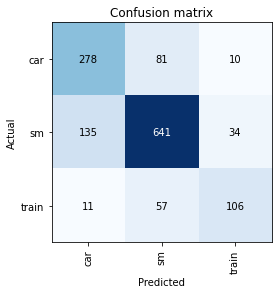

In [ ]:
interp.plot_confusion_matrix()

## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X_train, y_train = dls.train.xs, dls.train.ys.values.ravel()
X_test, y_test = dls.valid.xs, dls.valid.ys.values.ravel()

In [ ]:
rf = RandomForestClassifier()

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
preds = rf.predict(X_test)

In [ ]:
(y_test == preds).mean() * 100

79.5269770879527